# Classification exercise in HEP

## Example of KERAS-based DNN implementation of an LHC sarch analysis

It is inspired by the work shown in Baldi et al.
(https://arxiv.org/abs/1402.4735), and it uses as data samples the ones accompanying that paper, and available as

https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

and

https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz.

## Definition of the physics problem

Each of the samples includes a large sample of simulated LHC events, chracterised by a well defined final state. 
For the HIGGS sample the final state is two jets coming from the fragmentation of two b-quarks, and the decay 
products of two W bosons. If we adress the case where one of the W decays into a lepton and a neutrino, and the 
other decays into two jets, we have four jets, 1 lepton and the measured imbalance of the momentum in the plane. 
For each of the jets/lepton the 4-momentum is stored in the datafiles, in the standard coordinate system used in 
collider experiments, and the two components on the of the tranverse momentum imbalance (MET), which represent 
a measurement of the two transverse components of the momentum of the neutrino which escapes detection.
Each event has a label 0 or 1, which will be named SIG, where 1 means that the event is a SIGNAL event, 
i.e. it was produced by the physical process we are trying to discover, and 0 means that the event is 
a BACKGROUND i.e. was produced by a known process, and we want to discard it. Our task is, based on the the 
information for each event which we have in the datafiles.

To be more specific, the signal events are diagrammatically represented as


Signal

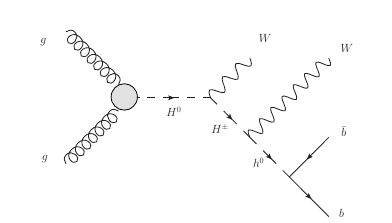



Background
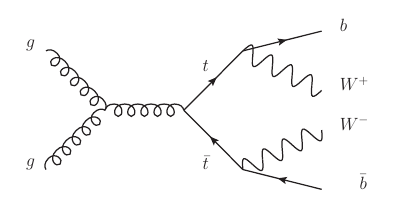

In the provided data the both Ws are decayed into a lepton and a neutrino, so the final state in both cases is: two leptons, two b-jets and Etmiss.

The 4-momenta for each of the visible particle and Etmiss are called 'Low level features'
Various invariant mass combination for the visible particles are called 'High level features'

All the variables are renormalised to have a mean value around one to make life easier for the DNN

## Data loading

The provided samples are of several million events, in order to fit into the colab memory and to have a reasonable execution speed during the lecture we provide in dropbox reduced samples of 240k events. To further speed up execution the sample can be further reduced m

In [1]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt


higgsusy=2

print("higgsusy switch ",higgsusy)

if higgsusy==1:

  link='https://www.dropbox.com/s/muyqdaw17iqxlnd/susyred1.csv.gz?dl=1' 


  features=['SIG','lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
            'MET_val', 'MET_phi', 'MET_rel', 'axial_MET',  'MT2']        

  low_features=['lep_1_pT', 'lep_1_eta', 'lep_1_phi', 'lep_2_pT', 'lep_2_eta', 'lep_2_phi',
                'MET_val', 'MET_phi']

  high_features=['MET_rel', 'axial_MET', 'MT2']
                  
if higgsusy==2:

  link='https://www.dropbox.com/s/vdnstm4qo24uppn/higgsred.csv.gz?dl=1'
  
  features=['SIG','lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 
            'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

  low_features=['lepton_pT', 'lepton_eta', 'lepton_phi', 'MET_val', 'MET_phi', 
            'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 
            'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']

  high_features=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

# define number of records that we want to read
N = 240000
print("Size of dataset : %i"%N)
df = pd.read_csv(link, compression='gzip', header=None,nrows=N,engine='python')
#Name the columns using the 'features' array
df.columns=features
#Inspect contents
#print(df.head)
print ("data loaded")

higgsusy switch  2
Size of dataset : 240000
data loaded


## Inspect low level features in 1d 

7


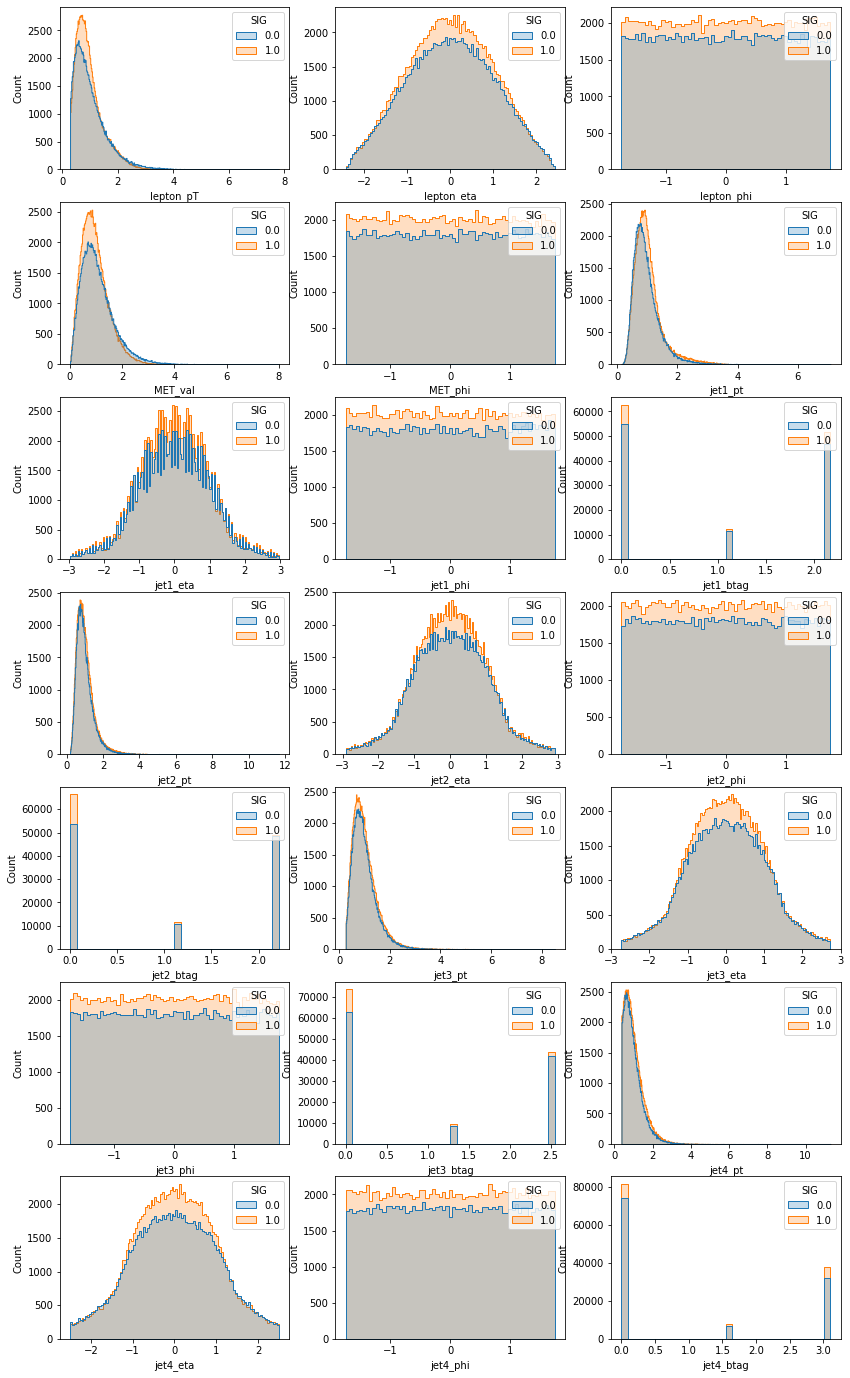

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plotvar=1
if plotvar==1:
# Look at variables: first basic kinematics
  nrow = int(len(low_features)/3)
  print(nrow)
  print 
  if(len(low_features)%3>0):
    nrow=nrow+1
  if nrow==0:
    nrow=1;
  fig, axes = plt.subplots(nrow,3  , figsize=(14, 3.5*nrow))  
  for ii in range (0, len(low_features)):
    idf=ii
    i1=int(ii/3)
    i2=ii%3
    sns.histplot( df, ax=axes[i1,i2], x=low_features[idf], hue="SIG",element="step")
  plt.show()

## Inspect high level features in 1d 

2


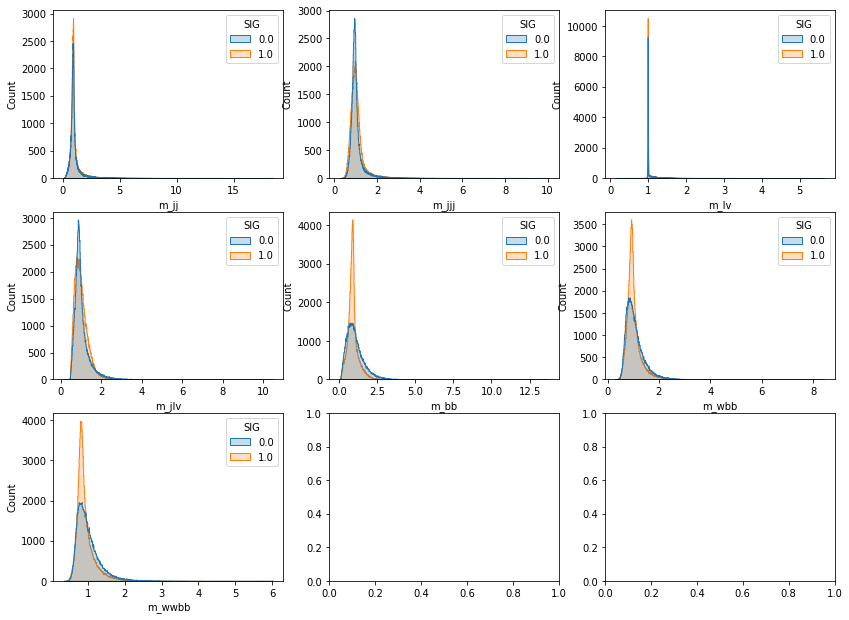

In [3]:
if plotvar==1:
  nrow = int(len(high_features)/3)
  print(nrow)
  if(len(high_features)%3>0):
     nrow=nrow+1
  if(nrow==0):
     nrow=1
  fig, axes = plt.subplots(nrow, 3  , figsize=(14, 3.5*nrow)) 
  for ii in range (0, len(high_features)):
    idf=ii
    i1=int(ii/3)
    i2=ii%3
    if(nrow>1):
      sns.histplot( df, ax=axes[i1,i2], x=high_features[idf], hue="SIG",element="step")
    if(nrow==1):
      sns.histplot( df, ax=axes[i2], x=high_features[idf], hue="SIG",element="step")
  plt.show()

Once we have loaded the data, we need to define the input vector X, including all of the columns except the label one, and the target vector including only the label.

For the X vector we prepare two  variations, the version  with only low-level variables, and the one with all of the variables. The first exercise will then be done using the full set of variables 

In [4]:
#Define vectors for input to NN 

# Use first column as definition of target
y = df['SIG'].values

# Three different sets: full, only low features

X = df[[col for col in df.columns if col!="SIG"]]
X_low=X[low_features]
X_high=X[high_features]

## Split training and test samples

We need to define a set for the training and a set for the test, sklearn provides a method which performs a splitting based on the desired size for  the test. In our case we separate 20% of the events. Then on the taining sample we separate the validation sample which will be used for monitoring the training

In [5]:
from sklearn.model_selection import train_test_split
# create test and train samples for both full feature set, and low level features
X_traina, X_test, y_traina, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=.1, random_state=0)
X_trainla, X_testl, y_trainla, y_testl = train_test_split(X_low, y, test_size=.2, random_state=0)
X_trainl, X_vall, y_trainl, y_vall = train_test_split(X_trainla, y_trainla, test_size=.1, random_state=0)

## Now define the neural network

In [6]:
#
#  define function for running NN, which in turn includes function 
#  for creating the model
#

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils     import plot_model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
# Define number of input variables as size of one row of the training dataframe
varnum=X_train.shape[1]
model = keras.Sequential()
# define common value for droput layer
drop=0.5
# add firstlayer
model.add(keras.layers.Dense(50, input_dim=varnum, activation='tanh'))
# add this line if you want to add adropout layer after the dense layer
#
#model.add(Dropout(drop))
# replace the dense layer with this if you want to regularize it
#
#
#model.add(keras.layers.Dense(50,  kernel_regularizer=l2(reg), activation='tanh'))
model.add(keras.layers.Dense(50,  activation='tanh'))
model.add(keras.layers.Dense(50,  activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
#model.add(keras.layers.Dense(1, input_dim=varnum,activation='sigmoid'))
model.summary()

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#  Set up callbacks during optimisation 
#
#  define early stopping. The programme monitors the value of the validation loss, and it
#  stops the optimisation when it does not decrease for 'patience' validation epochs
#  one has to put a patience parameter because the validation loss may fluctuate
#  and because one the optimisation may flattem out for some time and then restart
#
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
#
#  whenever the loss value is improved save the model, in this way at the end 
#  of the optimisation one will have the best model found on disk
#
savemod = "mod_save.h5"
mc = ModelCheckpoint(savemod, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
#
#  log onto file the values of accuracy and loss for each step in the optimisation
#
savelog="log_save.h5"
hl = CSVLogger(savelog, separator=",", append=False)
#
#  fit model
#
#  early stopping
#
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                         batch_size=200, epochs=200000, callbacks=[es, mc, hl], verbose=0)
epochs=50
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                         batch_size=200, epochs=epochs, callbacks=[mc, hl], verbose=0)
#
# fixed number of epochs
#
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])



2023-05-23 14:56:21.210849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 14:56:21.248755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 14:56:21.248964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 14:56:22.045201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1450      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_loss improved from inf to 0.67454, saving model to mod_save.h5

Epoch 2: val_loss improved from 0.67454 to 0.66057, saving model to mod_save.h5

Epoch 3: val_loss improved 

<b>Exercises</b>:

1) Try different parameter settings:

  * relu instead of tanh

  * modify learning rate  of SGD optimizer : truy 0.1 or 0.05
    
  * change optimizer:  try Adam
  
  * try dropout and/or regularisation
    
2) Extract corresponding results for SUSY sample: compare all and low level variables

## Run prediction

In [7]:
Ypredt=model.predict(X_test)

1500/1500 [==============================] - 1s 931us/step


## Create dataframe with labels and probabilities 

In [8]:
df_test=X_test.copy()
df_test['SIG']=y_test
df_test['PROB']=Ypredt

# Look at the classification performance

## Plot history of losses along epochs for Keras

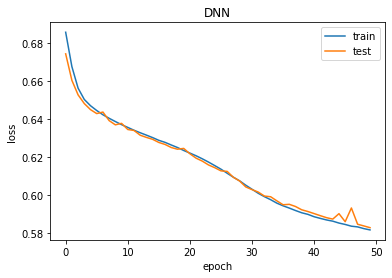

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.


nsig  25305
nbkg  22695


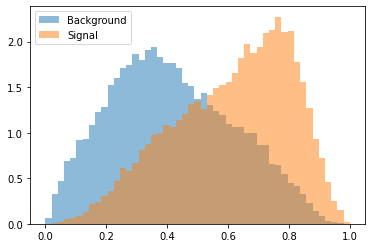

In [10]:
# split according to the label
df_test_bkg = df_test.query('SIG==0')
df_test_sig = df_test.query('SIG==1')
print('nsig ',df_test_sig.shape[0])
print('nbkg ',df_test_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

## Plot ROC curve and calculate AUC

DNN auc  0.7583525274532397


<function matplotlib.pyplot.show(close=None, block=None)>

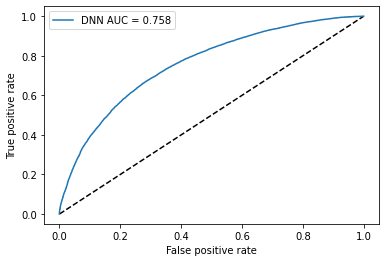

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

plt.plot([0.001, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
auc_keras = auc(fpr_keras, tpr_keras)
print("DNN auc ",auc_keras)
plt.plot(fpr_keras, tpr_keras, label='DNN AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show    


## Plot significance

DNN:
 max significance is   1.7760111965256042  nbg  1051.5532055518836  nsig  58.10709345979056  cut  0.5948542
 background efficiency:  0.21031064111037673  signal efficiency:  0.5810709345979056


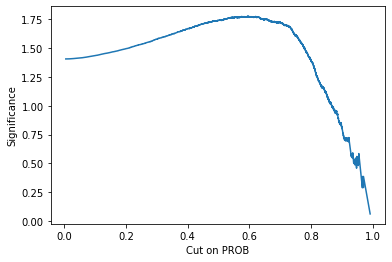

In [12]:
from numpy import sqrt
from math import log
from numpy import nanmax

def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

#
#  Define signal background and error
#
nsig=100
nbg=5000
bfr=0.05
errfbg=0.001
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
n_bg=fpr_keras*nbg
n_sig=tpr_keras*nsig
errbg=errfbg*n_bg
signi=[]
thr=[]      
for i in range(1,len(n_sig)):
    if(thresholds_keras[i]>0.):
      signi.append(calc_sig(n_sig[i],n_bg[i],errbg[i]))
      thr.append(thresholds_keras[i])        
imax=-1
signimax=0.
for i in range(0,len(signi)):
  if signi[i]>signimax:
      imax=i
      signimax=signi[i]  
maxs=nanmax(signi)
lab="DNN"
print(lab+":") 
print(" max significance is  ",signimax," nbg ",n_bg[imax]," nsig ",n_sig[imax]," cut ",thresholds_keras[imax])
print(" background efficiency: ", n_bg[imax]/nbg," signal efficiency: ", n_sig[imax]/nsig )
plt.plot(thr,signi, label=lab)
thropt=thresholds_keras[imax]
    
plt.xlabel('Cut on PROB')
plt.ylabel('Significance')
plt.show()

One sees that for a HEP analysis, in a high background environment one goes for very high rejection factors on the background, accepting a relatively low background efficiency (typical values in a LHC search analysis are order a few percent)

<b>Exercise</b>: Play around with  the parameters nsigtot, nbgtot and errfbg to understand how the sensitivity depends on the total number of signal and background events,  and on the uncertainty on background estimate   estimate

## Compare with cut and count

Compare now with performance using a cut and count selection

In [13]:

import math
from math import sqrt

# apply a selection on variables
cut='m_bb<0.95 and m_bb>0.8 and m_wbb>0.89 and m_wwbb<0.87 and m_wwbb>0.775'
df_sel_sig = df_test_sig.query(cut)
df_sel_bkg = df_test_bkg.query(cut)
# calculate and print the efficency of the selection
beff=df_sel_sig.shape[0]/df_test_sig.shape[0]
seff=df_sel_bkg.shape[0]/df_test_bkg.shape[0]
nsigcc=beff*nsig
nbkgcc=seff*nbg
nbExpErcc=nbkgcc*bfr
sigcc=calc_sig(nsigcc, nbkgcc, nbExpErcc)
print(" cc significance is  ",sigcc," nbg ",nbkgcc," nsig ",nsigcc)
print(" background efficiency: ", beff," signal efficiency: ", seff )



 cc significance is   1.1498120376921022  nbg  51.99383124036132  nsig  9.089112823552657
 background efficiency:  0.09089112823552657  signal efficiency:  0.010398766248072263


## Compare label and prediction in 1-d projections

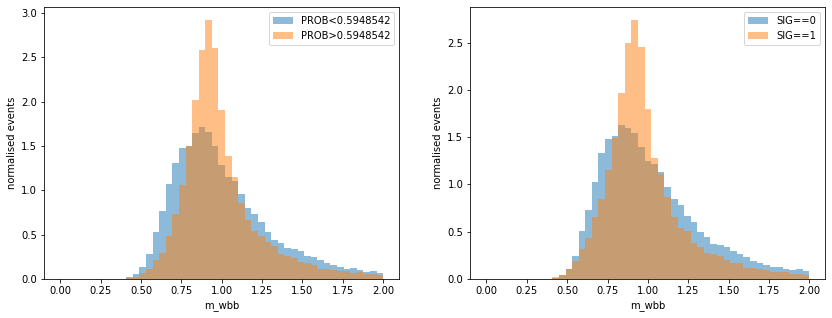

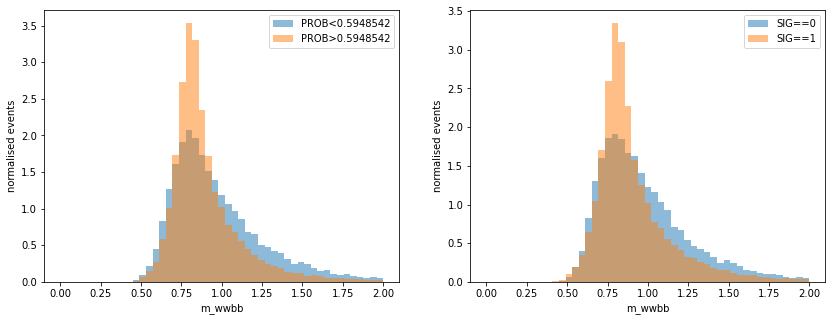

In [14]:
pred_false='PROB<'+str(thropt)
pred_true='PROB>'+str(thropt)
lab_false='SIG==0'
lab_true='SIG==1'
nbin=50
blow=0.
bhigh=2.
bins = np.linspace(blow, bhigh, nbin)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="m_wbb"
plt.hist(df_test.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
var="m_wwbb"
plt.hist(df_test.query(pred_false)[var], bins, alpha=0.5, density=True, label=pred_false)
plt.hist(df_test.query(pred_true)[var], bins, alpha=0.5, density=True, label=pred_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.subplot(1, 2,2)
plt.hist(df_test.query(lab_false)[var], bins, alpha=0.5, density=True, label=lab_false)
plt.hist(df_test.query(lab_true)[var], bins, alpha=0.5, density=True, label=lab_true)
plt.legend(loc='best')
plt.xlabel(var)
plt.ylabel('normalised events')
plt.show()

## Visualise patterns in 2-d space

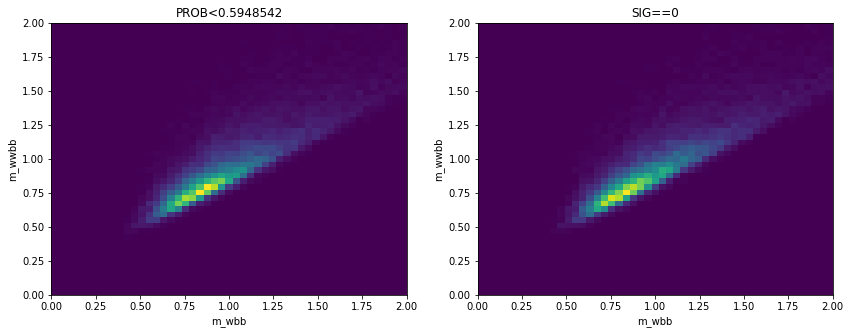

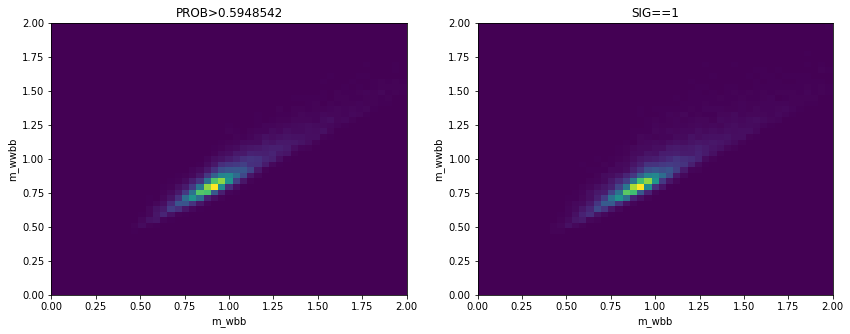

In [15]:
varx="m_wbb"
varminx=0.
varmaxx=2.
nbinx=50
scalex=1.
vary="m_wwbb"
nbiny=50
varminy=0.
varmaxy=2.
scaley=1.
binx = np.linspace(varminx,varmaxx,nbinx)
biny = np.linspace(varminy,varmaxy,nbiny)
fig1= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test.query(pred_false)[varx]*scalex, df_test.query(pred_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_false)
plt.subplot(1, 2,2)
plt.hist2d(df_test.query(lab_false)[varx]*scalex, df_test.query(lab_false)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_false)
plt.show()
fig2= plt.figure(figsize=(14,5))
plt.subplot(1, 2,1)
plt.hist2d(df_test.query(pred_true)[varx]*scalex, df_test.query(pred_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(pred_true)
plt.subplot(1, 2,2)
plt.hist2d(df_test.query(lab_true)[varx]*scalex, df_test.query(lab_true)[vary]*scaley, 
           bins=[binx, biny], density=False)
plt.xlabel(varx)
plt.ylabel(vary)
plt.title(lab_true)
plt.show()